In [30]:
#conda install -c conda-forge librosa

# Package Import

In [164]:
import pandas as pd
import librosa
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [307]:
_3sec = pd.read_csv('Data/features_3_sec.csv')
_30sec = pd.read_csv('Data/features_30_sec.csv')

---

## MP3 TO CSV CONVERSION:

In [33]:
def mp3_to_df(filename):
    y,sr = librosa.load(filename)
    length = len(y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean()
    chroma_stft_var = chroma_stft.var()
    rms = librosa.feature.rms(y=y)
    rms_mean = rms.mean()
    rms_var = rms.var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = spectral_centroid.mean()
    spectral_centroid_var = spectral_centroid.var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    spectral_bandwidth_var = spectral_bandwidth.var()
    rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr)
    rolloff_mean = rolloff.mean()
    rolloff_var = rolloff.var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_var = zero_crossing_rate.var()
    harmony = librosa.feature.tempogram(y=y, sr=sr)
    harmony_mean = harmony.mean()
    harmony_var = harmony.var()
    perceptr = librosa.effects.percussive(y=y)
    perceptr_mean = perceptr.mean()
    perceptr_var = perceptr.var()
    tempo = librosa.beat.tempo(y=y, sr=sr).mean()
    row = [[length,chroma_stft_mean,chroma_stft_var,
           rms_mean,rms_var,spectral_centroid_mean,
           spectral_centroid_var,spectral_bandwidth_mean,
           spectral_bandwidth_var,rolloff_mean,rolloff_var,
           zero_crossing_rate_mean,zero_crossing_rate_var,
           harmony_mean,harmony_var,perceptr_mean,
           perceptr_var,tempo]]
    df = pd.DataFrame(row, columns = 
                      ['length','chroma_stft_mean','chroma_stft_var',
                       'rms_mean','rms_var','spectral_centroid_mean',
                       'spectral_centroid_var','spectral_bandwidth_mean',
                       'spectral_bandwidth_var','rolloff_mean','rolloff_var',
                       'zero_crossing_rate_mean','zero_crossing_rate_var',
                       'harmony_mean','harmony_var','perceptr_mean',
                       'perceptr_var','tempo'])
    mfcc_arr = librosa.feature.mfcc(y=y, sr=sr)
    for i in range(len(mfcc_arr)):
        mean_colname = 'mfcc'+str(i+1)+'_mean'
        var_colname = 'mfcc'+str(i+1)+'_var'
        df[mean_colname] = mfcc_arr[i].mean()
        df[var_colname] = mfcc_arr[i].var()
    return df

---

# Pre-Processing:

## PCA & Normalization

In [34]:
'''
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 0.95)
    X = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
    X_train = pd.DataFrame(data = X_train)
    X_test = pd.DataFrame(data = X_test)
    return X_train, X_test, y_train, y_test
'''

'\ndef preprocessing(data):\n    X = data.iloc[:,19:59:2]\n    y = data.iloc[:,-1]\n    X = StandardScaler().fit_transform(X)\n    pca = PCA(n_components = 0.95)\n    X = pca.fit_transform(X)\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)\n    X_train = pd.DataFrame(data = X_train)\n    X_test = pd.DataFrame(data = X_test)\n    return X_train, X_test, y_train, y_test\n'

In [35]:
'''
X_train,X_test,Y_train,Y_test = preprocessing(_30sec)
'''

'\nX_train,X_test,Y_train,Y_test = preprocessing(_30sec)\n'

In [338]:
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    #pca = PCA(n_components=0.95)
    #X = pca.fit_transform(X)
    return X, y

In [339]:
X, y = preprocessing(_30sec)

In [340]:
X

array([[ 0.30847037,  0.70309345, -0.47269061, ..., -0.23704039,
         0.00672291,  0.60406407],
       [-0.62915912,  0.78035534,  0.82451842, ..., -0.05498165,
         0.54480563,  0.42412706],
       [ 0.53654201,  1.30582023, -0.93052389, ..., -0.60098294,
        -0.29593404, -0.29618888],
       ...,
       [ 0.19485783,  0.4988911 , -1.8014377 , ...,  0.75850843,
        -2.73284378, -0.26361549],
       [-0.80390641,  0.76935388, -0.03707979, ...,  0.27113131,
        -0.72271696, -0.65064889],
       [-0.9052669 ,  0.77648646, -0.62814629, ..., -0.12395377,
         0.08070645,  0.5868411 ]])

# Agglomerative Model:

## Model Building

In [199]:
_30_base_model = sklearn.cluster.AgglomerativeClustering(n_clusters=10, linkage='ward', compute_distances=True).fit(X)

In [200]:
_30_base_model.get_params()

{'affinity': 'euclidean',
 'compute_distances': True,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 10}

Create function for displaying **dendrograms**:

In [201]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [202]:
uq,counts = np.unique(_30_base_model.labels_, return_counts= True)
class_freq = {uq[i]:counts[i] for i in range(len(uq))}
class_freq = dict(sorted(class_freq.items(), key=lambda item: item[1]))

In [203]:
for k,v in class_freq.items():
    print(f'Cluster ID: {k}\tNumber of Data in Cluster: {v}')

Cluster ID: 4	Number of Data in Cluster: 23
Cluster ID: 9	Number of Data in Cluster: 49
Cluster ID: 8	Number of Data in Cluster: 60
Cluster ID: 7	Number of Data in Cluster: 63
Cluster ID: 6	Number of Data in Cluster: 85
Cluster ID: 3	Number of Data in Cluster: 106
Cluster ID: 1	Number of Data in Cluster: 125
Cluster ID: 5	Number of Data in Cluster: 142
Cluster ID: 2	Number of Data in Cluster: 154
Cluster ID: 0	Number of Data in Cluster: 193


## Display Dendrogram

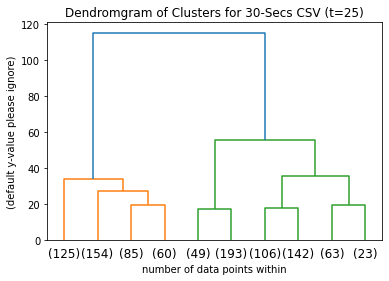

In [204]:
plt.title("Dendromgram of Clusters for 30-Secs CSV (t=25)")
plot_dendrogram(_30_base_model, truncate_mode='lastp', p=10)
plt.xlabel('number of data points within')
plt.ylabel('(default y-value please ignore)')
plt.show()

## Step 4. Validation

Convert both features data into 3-dimesional for cluster plotting:

In [210]:
X_og = _30sec.iloc[:,19:59:2]
X_og = StandardScaler().fit_transform(X_og)
X_2d = PCA(2).fit_transform(X_og)

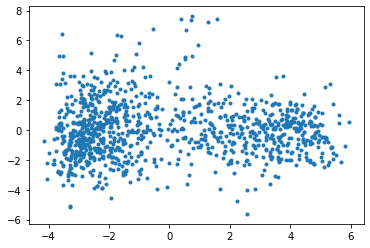

In [211]:
plt.scatter(X_2d.T[0], X_2d.T[1], marker='.')

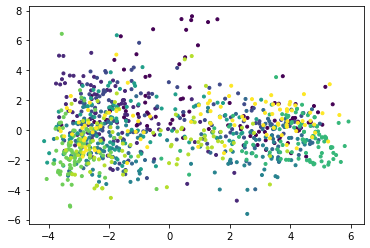

In [212]:
plt.scatter(X_2d.T[0], X_2d.T[1], c=np.unique(y, return_inverse=True)[1], marker='.')

In [213]:
yhat = _30_base_model.labels_

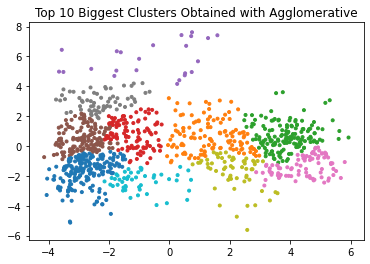

In [214]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(X_2d.T[0], X_2d.T[1], c=yhat, cmap=color, marker='.')
plt.title('Top 10 Biggest Clusters Obtained with Agglomerative')
plt.show()

---

## Obtain Optimal Distance Threshold (For next presentation)

Fit null model:

In [359]:
_30_original = sklearn.cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0, compute_distances=True).fit(X)

Obtain all possible distances:

In [360]:
_30_distances = _30_original.distances_

Use **Extreme Value Theory** to find optimal distance threshold:

Ref:<br>
*Li, C., Günther, M., Dhamija, A. R., Cruz, S., Jafarzadeh, M., Ahmad, T., & Boult, T. E. (2022). Agglomerative Clustering with Threshold Optimization via Extreme Value Theory. Algorithms, 15(5), 170.*

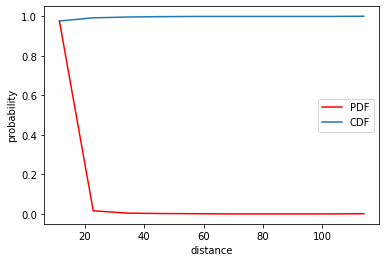

In [361]:
count, bins_count = np.histogram(_30_distances)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.xlabel('distance')
plt.ylabel('probability')
plt.legend()

In [362]:
_30_base_model = sklearn.cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold = 23).fit(X)

In [363]:
uq,counts = np.unique(_30_base_model.labels_, return_counts= True)
class_freq = {uq[i]:counts[i] for i in range(len(uq))}
class_freq = dict(sorted(class_freq.items(), key=lambda item: item[1]))

In [364]:
for k,v in class_freq.items():
    print(f'Cluster ID: {k}\tNumber of Data in Cluster: {v}')

Cluster ID: 6	Number of Data in Cluster: 9
Cluster ID: 4	Number of Data in Cluster: 68
Cluster ID: 3	Number of Data in Cluster: 79
Cluster ID: 2	Number of Data in Cluster: 84
Cluster ID: 8	Number of Data in Cluster: 84
Cluster ID: 5	Number of Data in Cluster: 108
Cluster ID: 7	Number of Data in Cluster: 110
Cluster ID: 0	Number of Data in Cluster: 227
Cluster ID: 1	Number of Data in Cluster: 231


In [365]:
yhat = _30_base_model.labels_

In [366]:
X_og = _30sec.iloc[:,19:59:2]
X_og = StandardScaler().fit_transform(X_og)
X_2d = PCA(2).fit_transform(X_og)

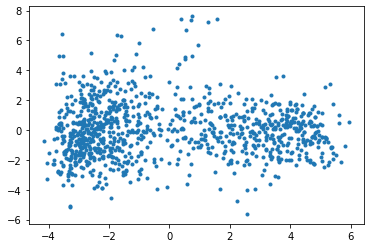

In [349]:
plt.scatter(X_2d.T[0], X_2d.T[1], marker='.')

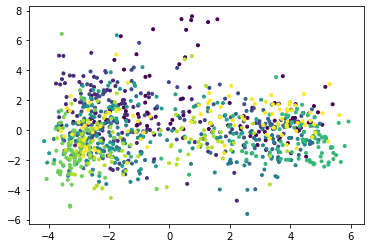

In [350]:
plt.scatter(X_2d.T[0], X_2d.T[1], c=np.unique(y, return_inverse=True)[1], marker='.')

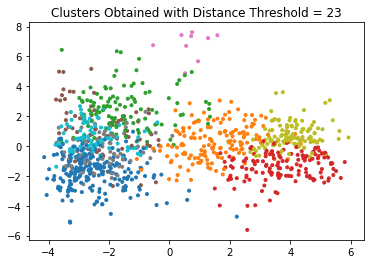

In [353]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(X_2d.T[0], X_2d.T[1], c=yhat, cmap=color, marker='.')
plt.title('Clusters Obtained with Distance Threshold = 23')
plt.show()

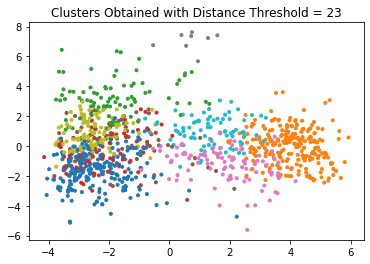

In [367]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(X_2d.T[0], X_2d.T[1], c=yhat, cmap=color, marker='.')
plt.title('Clusters Obtained with Distance Threshold = 23')
plt.show()

In [357]:
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=0.95)
    X = pca.fit_transform(X)
    return X, y

In [358]:
X, y = preprocessing(_30sec)